# PyMCon 2020 - Oct 31

## Demystifying Variational Inference


<br />
<br />

GitHub - https://github.com/Sayam753/PyMCon-talk

Twitter - @sayamkumar753

Blog - https://www.codingpaths.com

## Today's agenda

 - Bayes Rules
 - Variational Inference
 - Approximations
 - Out of the box implementations
 - Model diagonistics

## Bayes Formula

We define our posterior in terms of likelihood and priors.
$$
P\left (\theta | D\right ) = \frac{P\left (D|\theta\right ) * P\left (\theta\right )}{P\left (D\right )}
$$

$\theta$ = Parameters of the model, $D$ is the data

$$
P\left (\theta | D\right ) = \frac{P\left (D|\theta\right ) * P\left (\theta\right )}{\int P\left (D|\theta\right ) P\left (\theta\right ) d\left (\theta\right )}
$$

In [1]:
import arviz as az
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc4 as pm4
import tensorflow as tf
import tensorflow_probability as tfp
import xarray as xr

logging.getLogger("tensorflow").setLevel(logging.ERROR)
%matplotlib inline

INFO:tensorflow:Using local port 21965
INFO:tensorflow:Using local port 23096
INFO:tensorflow:Using local port 17196
INFO:tensorflow:Using local port 21942
INFO:tensorflow:Using local port 23119
INFO:tensorflow:Using local port 20393
INFO:tensorflow:Using local port 23002
INFO:tensorflow:Using local port 23173
INFO:tensorflow:Using local port 21695
INFO:tensorflow:Using local port 19811


In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
plt.style.use('arviz-darkgrid')

dtype = tf.float32
tfb = tfp.bijectors
tfd = tfp.distributions

## Example

Infer $\mu$ and $\sigma$ for Normal distribution.

In [3]:
# Generating data
mu = 12
sigma = 2.2
data = np.random.normal(mu, sigma, 1000)

In [4]:
# Defining the model
model = tfd.JointDistributionSequential([
    # sigma_prior
    tfd.Exponential(1.),

    # mu_prior
    tfd.Normal(loc=0., scale=1.),

    # likelihood
    lambda mu, sigma: tfd.Normal(loc=mu, scale=sigma, name="ll")
])

In [5]:
print(model.resolve_graph())

(('sigma', ()), ('mu', ()), ('ll', ('mu', 'sigma')))


### Joint Log Prob

- Or so called unnormalized product of likelihood and priors given the samples and data.
- We consider log probability to avoid floating points in multiplication of probabilities.

In [6]:
# Let's generate joint log probability
def joint_log_prob(*samples):
    log_prob_parts = model.log_prob_parts(samples + (data,))
    return sum(map(tf.reduce_sum, log_prob_parts))

### What about MCMC?
* A sampling algorithm to compute posterior.
* We can get exact posterior if we sample for long enough.
* Can we go better in terms of time complexity and generate similar results.

### Variational Inference

Variational Inference (VI) turns the task of computing the posterior p(z|x) into an optimization problem. We pose a **family of distributions**  $q(z)$ and chose the one that is closest to the posterior 

### Information and KL divergence

For measuring similarity between our approximating distribution and posterior, we will use KL divergence. It is just the difference between average information. 

$$
KL(q(\theta)||p(\theta|D)) = \int q(\theta) \log \left( \frac{q(\theta)}{p(\theta|D)} \right) d\theta\\
$$

### Evidence Lower Bound

There is again an issue with KL divergence formula as it still involves posterior term i.e. $p(\theta|D)$. Let's get rid of it -

$$
KL(q(\theta)||p(\theta|D)) = \int q(\theta) \log \left( \frac{q(\theta)}{p(\theta|D)} \right) d\theta\\
KL = \int q(\theta) \log \left( \frac{q(\theta) p(D)}{p(\theta, D)} \right) d\theta\\
KL = \int q(\theta) \log \left( \frac{q(\theta)}{p(\theta, D)} \right) d\theta + \int q(\theta) \log \left(p(D) \right) d\theta\\
KL + \int q(\theta) \log \left( \frac{p(\theta, D)}{q(\theta)} \right) d\theta = \log \left(p(D) \right) \int q(\theta) d\theta\\
$$

Identifying terms -

$$
\int q(\theta) d\theta = 1
$$


### Evidence Lower Bound

$$
KL + \int q(\theta) \log \left( \frac{p(\theta, D)}{q(\theta)} \right) d\theta = \log \left(p(D) \right)
$$

The term $\int q(\theta) \log \left( \frac{p(\theta, D)}{q(\theta)} \right) d\theta$ is called (ELBO).

$$
ELBO = E_{q(\theta)}\left [\log \left( \frac{p(\theta, D)}{q(\theta)} \right) \right]\\
$$

### We are going to maximize the ELBO.

$$
\nabla ELBO = E_{q(\theta)}\left(\nabla \left(\log p(\theta, D) - \log q(\theta) \right) \right)
$$

### Monte Carlo Approximation

For n samples drawn from approximating posterior -

$$
\nabla ELBO \approx \frac{1}{n} \sum_{i=1}^{n} \left(\log p(\theta_i, D) - \log q(\theta_i) \right) \nabla \log q(\theta_i)
$$

In [7]:
def variational_loss(target_log_prob, approximating_posterior, sample_size):
    def monte_carlo_expection():
        samples = approximating_posterior.sample(sample_size)
        samples = approximating_posterior.log_prob(samples) - target_log_prob(samples)
        return tf.reduce_mean(samples, axis=0)  # Monte carlo expectation

    return monte_carlo_expection

<img src="https://ih1.redbubble.net/image.1558993336.0259/raf,750x1000,075,t,FFFFFF:97ab1c12de.jpg" width=350px>

#### Overflow can be in `target_log_prob`

### Transformations

We optimize ELBO in unbounded space and we need transformations to match support of distributions for samples drawn from posterior.

If $T$ is the transformation from unconstrained to constrained space, then -
$$
p\left (D, \zeta \right) = p\left (D, T\left (\zeta \right) \right) \left | det J_{T}(\zeta)  \right |\\
\log p\left (D, \zeta \right) = \log (p\left (D, T\left (\zeta \right) \right) + \log \left( det J_t(\zeta) \right)
$$

In [8]:
contraining_bijectors = [
  tfb.Exp(),
  tfb.Identity()
]


def make_transformed_log_prob(joint_log_prob, contraining_bijectors):

    def transformed_log_prob(samples):
        constrained_samples = list()
        for bij, sample in zip(contraining_bijectors, samples):
            constrained_samples.append(bij.forward(sample))

        tlp = joint_log_prob(*constrained_samples)
        ldj = [
            bij.forward_log_det_jacobian(s, event_ndims=bij.forward_min_event_ndims)
            for bij, s in zip(contraining_bijectors, samples)
        ]

        return tlp + sum(map(tf.reduce_sum, ldj))
    return transformed_log_prob


transformed_log_prob = make_transformed_log_prob(joint_log_prob, contraining_bijectors)

### Who does not like vectorizing code

In [9]:
def vectorized_log_prob(logp):
    def vectorize_logpfn(*samples):
        return tf.vectorized_map(lambda sample: logp(*sample), samples)
    return vectorize_logpfn


target_log_prob = vectorized_log_prob(transformed_log_prob)

### Mean Field ADVI

$$
q(\zeta) = \prod_{i=1}^{k} N(\zeta_k; \mu_k, \sigma^2_k)
$$

####  Assume variational parameters are uncorrelated.

In [10]:
def build_mf_advi():
    """Build Mean Field posterior assuming all parameters are normally distributed."""
    parameters = model.sample(1)
    parameters.pop()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter[0].shape
        loc = tf.Variable(
            tf.random.normal(shape, dtype=dtype),
            name=f'meanfield_{i}_loc',
            dtype=dtype
        )
        scale = tfp.util.TransformedVariable(
            tf.fill(shape, value=tf.constant(0.02, dtype=dtype)),
            tfb.Softplus(),  # For positive values of scale
            name=f'meanfield_{i}_scale'
        )

        approx_parameter = tfd.Normal(loc=loc, scale=scale)
        dists.append(approx_parameter)
    return tfd.JointDistributionSequential(dists)


meanfield_advi = build_mf_advi()

In [11]:
def make_optimizer_function(loss_fn, opt):

    @tf.function(autograph=False)
    def optimizer_fn():
        with tf.GradientTape() as tape:
            loss = loss_fn()

        watched_variables = tape.watched_variables()
        grads = tape.gradient(loss, watched_variables)
        train_op = opt.apply_gradients(zip(grads, watched_variables))
        return loss

    return optimizer_fn

In [12]:
def training_body(optimizer_fn):

    def loop_body(step, traced_loss):
        loss = optimizer_fn()
        traced_loss = traced_loss.write(step, loss)
        return [step+1, traced_loss]

    return loop_body

In [13]:
def fit(
    target_log_prob,
    approximating_posterior,
    num_steps,
    sample_size,
    opt
):
    loss_fn = variational_loss(target_log_prob, approximating_posterior, sample_size)
    optimizer_fn = make_optimizer_function(loss_fn, opt)

    traced_loss = tf.TensorArray(
        dtype=tf.float32,
        size=num_steps,
        clear_after_read=False,
    )

    _, traced_loss = tf.while_loop(
        cond=lambda *x: True,
        body=training_body(optimizer_fn),
        loop_vars=[0, traced_loss],
        parallel_iterations=1,
        maximum_iterations=num_steps - 1
    )
    return traced_loss

In [14]:
opt = tf.optimizers.Adam(learning_rate=1e-3)
traced_loss = fit(target_log_prob, meanfield_advi, 30_000, 2, opt)

In [15]:
[bij.forward(param) for bij, param in zip(contraining_bijectors, meanfield_advi.mean())]

[<tf.Tensor: shape=(), dtype=float32, numpy=2.1312032>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.002065>]

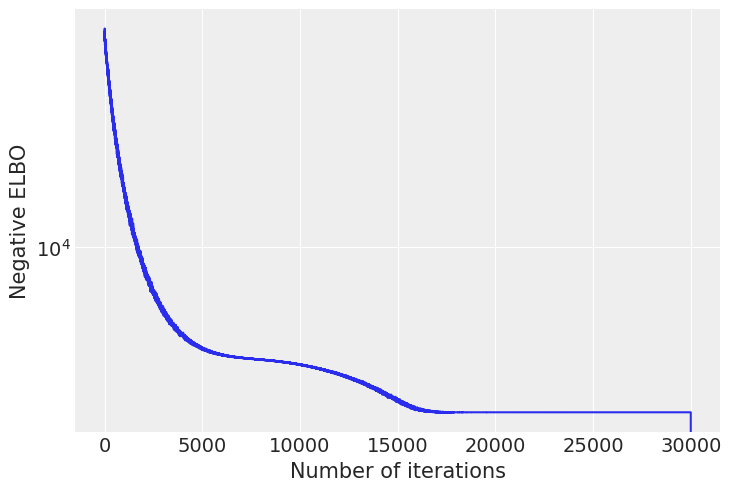

In [16]:
def plot_elbo(losses):
    plt.plot(losses)
    plt.yscale('log')
    plt.xlabel('Number of iterations')
    plt.ylabel('Negative ELBO')

plot_elbo(traced_loss.stack().numpy())

### What more one can do

- Progress bar
- Convergence checks
- Parameter Tracking
- Deterministics
- Minibatches

### Need just some minor tweaks to add all

## Modelling the correlation

### Full Rank ADVI
Pose a dense covariance matrix over all the parameters of the model.

### Low Rank ADVI 
Pose a rank diagonal update to covariance matrix.

We just need a flattened view of the parameters and approximating distribution.

### Out of the box implementations

#### TFP

Define log prob over flattened variables manually and pose an approximating distribution. We do have more control

#### PyMC3/4

Define the model and call the variational inference machinery using `pm.fit`

In [17]:
@pm4.model
def model():
    mu_prior = yield pm4.Normal('mu', 0, 1)
    sigma_prior = yield pm4.Exponential('sigma', 1)
    ll = yield pm4.Normal('ll', mu_prior, sigma_prior, observed=data)

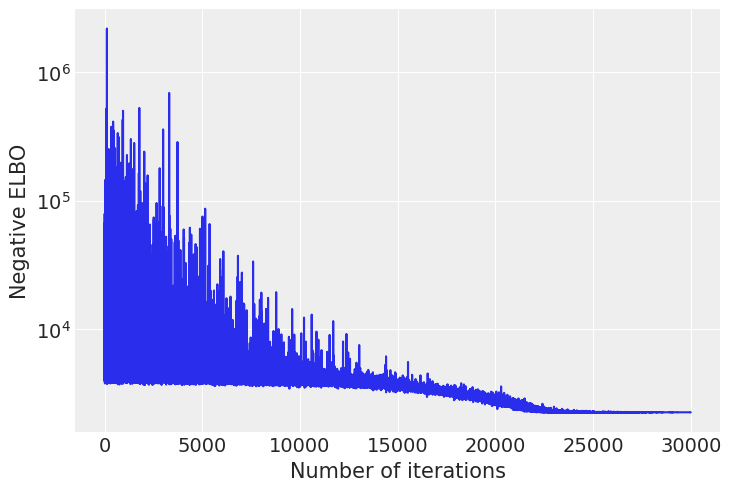

In [18]:
meanfield_advi = pm4.fit(model(), num_steps=30_000)
plot_elbo(meanfield_advi.losses)

### MCMC vs VI

 - If not interested in capturing correlation, we can start with Mean Field ADVI.
 - Tons of data, can opt for VI or if sampling is long enough.
 - If you can compromise accuracy, but want quick results.
 - Better approximations in VI as normalizing flows.

## Hierarchical Modelling with PyMC4

### Modelling Radon contamination (Gelman and Hill 2006)
 - Measurement in basement or first floor
 - Measurement of Uranium level available at county level

In [19]:
data = pd.read_csv(pm4.utils.get_data('radon.csv'))
u = np.log(data.Uppm).unique()
mn_counties = data.county.unique()
floor = data.floor.values.astype(np.int32)
floor = xr.DataArray(floor, dims=("obs_id"))

counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))
county_idx = data['county_code'].values.astype(np.int32)

#### Covariation intercept model

$$y \sim Normal(\theta, \sigma)$$

$$\theta = \alpha_{COUNTY} + \beta_{COUNTY} \times floor$$

$$\begin{bmatrix} \alpha_{COUNTY} \\ \beta_{COUNTY} \end{bmatrix} \sim MvNormal(\begin{bmatrix} \alpha \\ \beta \end{bmatrix}, \Sigma)$$

$$\Sigma = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}
     P
     \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}$$


Every correlation matrix can be split into product of its Lower Traingular cholesky factors. 
$$
P = L*L^T
$$

In [20]:
class CorrelationCholesky(pm4.distributions.transforms.BackwardTransform):
    name = "cholesky"

    def __init__(self):
        transform = tfb.CorrelationCholesky()
        super().__init__(transform)

In [21]:
@pm4.model
def hierarchical_model():
    sigma_slope = yield pm4.Exponential("sigma_slope", rate=1., batch_stack=2)
    cov = yield pm4.LKJCholesky('cov', dimension=2, concentration=2., transform=CorrelationCholesky())

    # Hyperpriors
    mu_a = yield pm4.Normal('mu_a', loc=0., scale=5.)
    mu_b = yield pm4.Normal('mu_b', loc=0., scale=5.)
    ab_county = yield pm4.MvNormalCholesky(
        'ab_county', tf.stack([mu_a, mu_b]), tf.linalg.LinearOperatorDiag(sigma_slope).matmul(cov), batch_stack=counties
        )

    loc = tf.gather(ab_county[:, 0], county_idx) + tf.gather(ab_county[:, 1], county_idx)*floor
    scale = yield pm4.Exponential("sigma", rate=1.)
    y = yield pm4.Normal('y', loc=loc, scale=scale, observed=data.log_radon.values)


In [22]:
mean_field = pm4.fit(hierarchical_model(), method="advi", num_steps=25_000, sample_size=10)
mean_field_samples = mean_field.approximation.sample(1000)
full_rank = pm4.fit(hierarchical_model(), method="fullrank_advi", num_steps=25_000, sample_size=10)
full_rank_samples = full_rank.approximation.sample(1000)

In [23]:
def remove_scope(idata):
    for group in idata._groups:
        for var in getattr(idata, group).variables:
            if "/" in var:
                idata.rename(name_dict={var: var.split("/")[-1]}, inplace=True)
    idata.rename(name_dict={"y_dim_0": "obs_id"}, inplace=True)

remove_scope(mean_field_samples)
remove_scope(full_rank_samples)

In [24]:
# Computing L.L^T
mean_field_samples.posterior["cov"].values = np.matmul(
    mean_field_samples.posterior["cov"].values,
    np.transpose(mean_field_samples.posterior["cov"].values, (0, 1, 3, 2))
)

full_rank_samples.posterior["cov"].values = np.matmul(
    full_rank_samples.posterior["cov"].values,
    np.transpose(full_rank_samples.posterior["cov"].values, (0, 1, 3, 2))
)

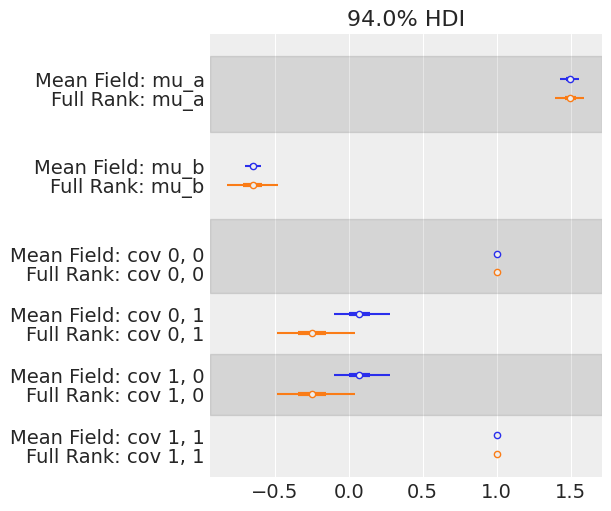

In [25]:
fig, axes = plt.subplots(figsize=(6, 5))
az.plot_forest(
    [mean_field_samples, full_rank_samples],
    model_names=["Mean Field", "Full Rank"],
    var_names=["mu_a", "mu_b", "cov"],
    combined=True,
    ax=axes
);

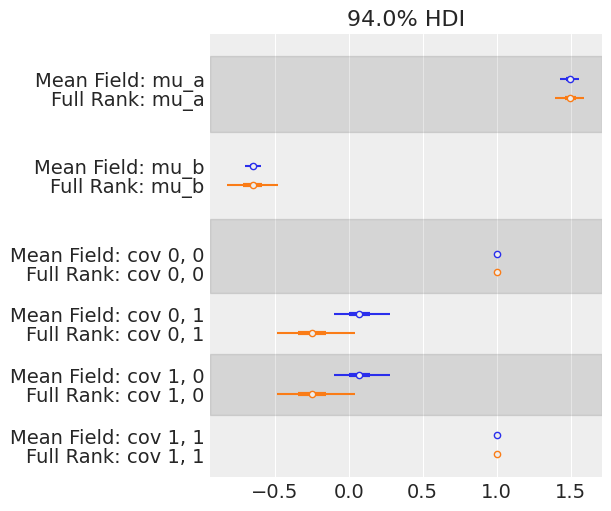

In [26]:
fig

Text(0, 0.5, 'Log radon level')

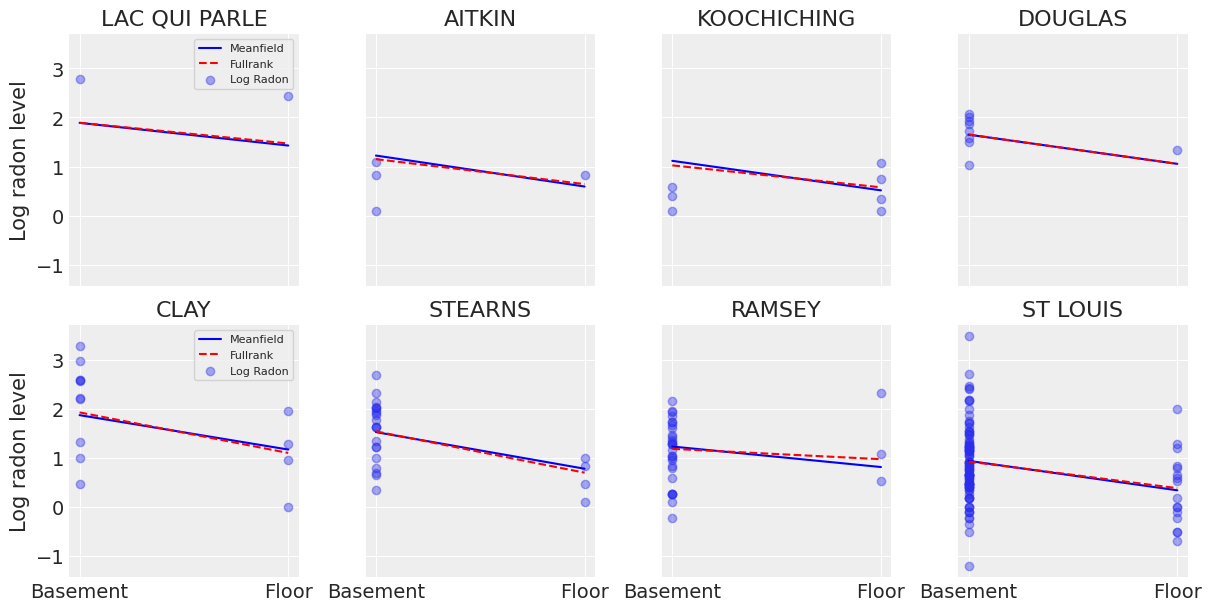

In [27]:
SAMPLE_COUNTIES = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "First Floor"]})
mean_field_samples.observed_data = mean_field_samples.observed_data.assign_coords({
    "County": ("obs_id", mn_counties[county_idx]),
    "Level": ("obs_id", np.array(["Basement", "Floor"])[floor.values.astype(np.int32)])
})
mv_county = mean_field_samples.posterior['ab_county']
full_mv_county = full_rank_samples.posterior['ab_county']

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
for ax, c in zip(axes.ravel(), SAMPLE_COUNTIES):
    sample_county_mask = mean_field_samples.observed_data.County.isin([c])

    # plot obs:
    mean_field_samples.observed_data.where(
        sample_county_mask, drop=True
    ).sortby("Level").plot.scatter(x="Level", y="y", ax=ax, alpha=.4, label="Log Radon")

    
    c_county = mv_county.sel(**{"chain": 0, "ab_county_dim_0": county_lookup[c]}).mean(dim=("draw"))
    full_c_county = full_mv_county.sel(**{"chain": 0, "ab_county_dim_0": county_lookup[c]}).mean(dim=("draw"))
    ax.plot([0, 1], c_county[0] + c_county[1]*xvals, "b", label="Meanfield")
    ax.plot([0, 1], full_c_county[0] + full_c_county[1]*xvals, "r--", label="Fullrank")
    
    ax.set_title(c); ax.set_xlabel(""); ax.set_ylabel("")
    
axes[0,0].legend(fontsize=8, frameon=True); axes[1,0].legend(fontsize=8, frameon=True);
axes[0,0].set_ylabel("Log radon level"); axes[1, 0].set_ylabel("Log radon level")
# fig.tight_layout();


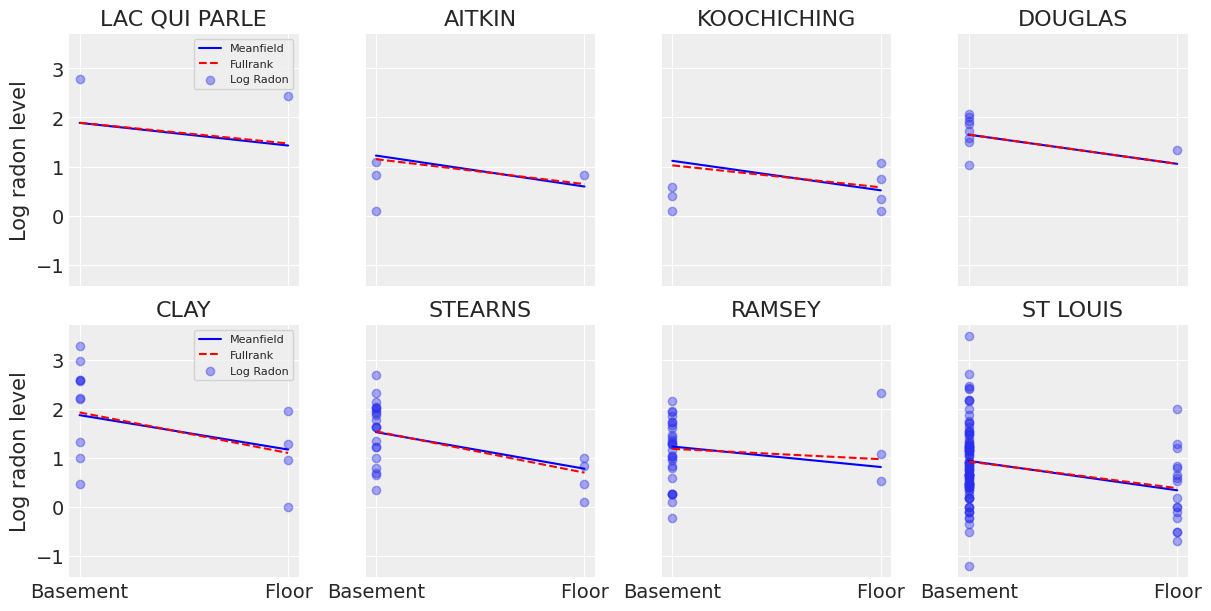

In [28]:
fig

In [29]:
mean_field.approximation.order.size

176

That's the flattened shape. Rank parameter to LowRank ADVI varies between 1 to 176.

## Diagonsing the model fit
- Perform convergence checks.
- Run the optimization for more iterations.
- Increase the sample_size to better approximate gradients.
- Use the approximation that minimized ELBO in last few iterations.
- Check with MCMC

### Take aways

 - An approximating approach to finding posterior.
 - Can customize degree of correlation.
 - For reasonable accuracies, mean field advi works all good.
 - Use PyMC3/4 for straight implementations.

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

tensorflow             2.4.0-dev20201009
numpy                  1.18.5
logging                0.5.1.2
pymc4                  4.0a2
pandas                 1.1.3
arviz                  0.10.0
tensorflow_probability 0.12.0-dev20201009
xarray                 0.16.1
last updated: Mon Oct 12 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2


## References

- Chapter 1 and 2: [Probabilistic Graphical Model Book]()
- Blog Post: [An Introduction to Probability and Computational Bayesian Statistics](https://ericmjl.github.io/essays-on-data-science/machine-learning/computational-bayesian-stats/) by [Ericmjl](https://github.com/ericmjl)
- Section 10.1: Variational Inference [Pattern Recognition and Machine Learning Book](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)
- Section 2.5: Transformations [Statistical Theory and Inference Book](http://www.ru.ac.bd/stat/wp-content/uploads/sites/25/2019/03/501_09_00_Olive-Statistical-Theory-and-Inference-2014.pdf)
- YouTube: [Variational Inference in Python](https://www.youtube.com/watch?v=3KGZDC3-_iY) by [Austin Rochford](https://github.com/AustinRochford)
- PyMC3: [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html)
- PyMC4: [Basic Usage Notebook](https://github.com/pymc-devs/pymc4/blob/master/notebooks/basic-usage.ipynb)
- TFP: [Joint Modelling Notebook](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb)
- Papers:
    - [Automatic Differentiation Variational Inference](https://arxiv.org/pdf/1603.00788.pdf). Kucukelbir, A., Tran, D., Ranganath, R., Gelman, A., and Blei, D. M. (2016).
    - [Automatic Variational Inference in Stan](https://arxiv.org/abs/1506.03431). Kucukelbir, A., Ranganath, R., Gelman, A., & Blei, D. (2015).

## Thank you

### Any questions